In [1]:
from __future__ import annotations

import pathlib

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)


Bad key axes.grid.axes in file matplotlibrc, line 17 ('axes.grid.axes: both')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.1/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
Bad value in file 'matplotlibrc', line 20 ("grid.color: '#6D6B71'"): Key grid.color: "'" does not look like a color arg


In [2]:
def load_data(directory: pathlib.Path) -> polars.DataFrame:
    dfs = []
    for run in directory.glob('**/results.csv'):
        try:
            df = polars.read_csv(run)
            if len(df) > 0:
                dfs.append(df)
        except Exception as e:
            print(f'Error loading {run}... skipping: {e}')
    return polars.concat(dfs)

In [3]:
data = load_data(pathlib.Path('../runs-prod/action-throughput-v1/'))

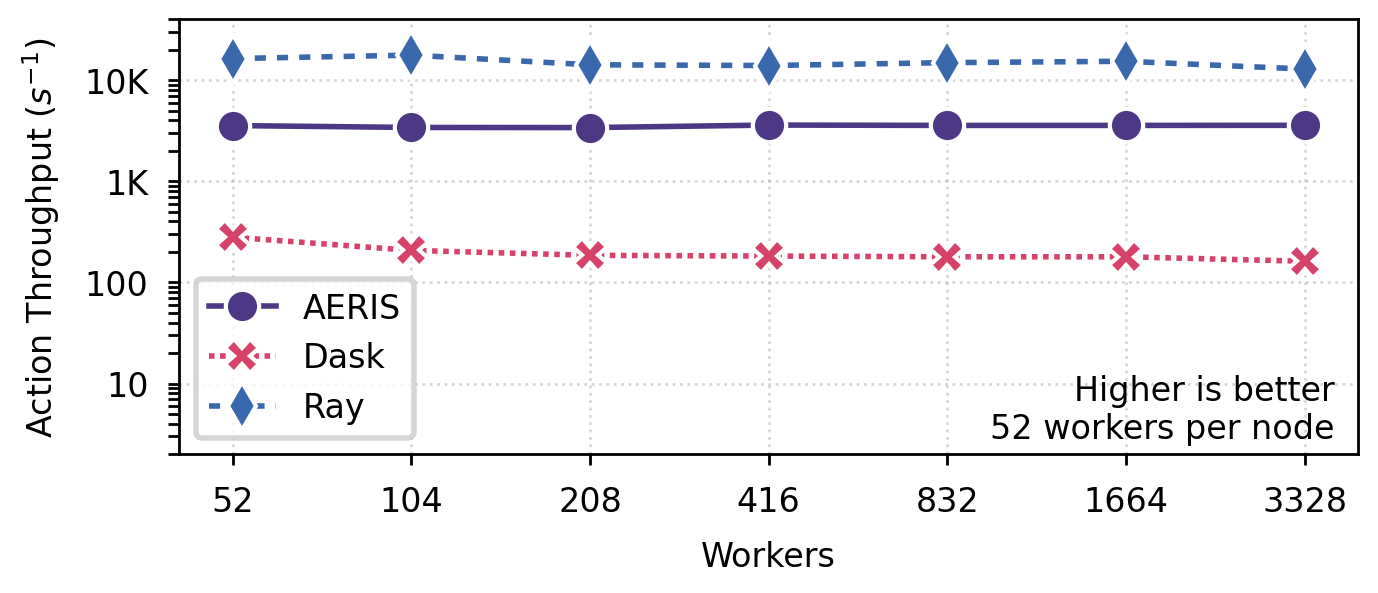

In [4]:
fig, axs = plt.subplots(1, 1)

results = data.with_columns(
    (
        polars.col('num_actors')
        * polars.col('actions_per_actor')
        / polars.col('runtime')
    ).alias('throughput'),
)

xticks = sorted(set(results['num_actors'].to_list()))
yticks = [10, 100, 1000, 10000]
yticklabels = ['10', '100', '1K', '10K']

dashes = {'ray': (2, 2), 'dask': (1, 1), 'aeris': ()}
markers = {'ray': 'd', 'dask': 'X', 'aeris': 'o'}
palette = {'ray': '#3969AC', 'dask': '#D64269', 'aeris': '#4D3886'}

handle = seaborn.lineplot(
    results,
    x='num_actors',
    y='throughput',
    hue='framework',
    hue_order=['ray', 'dask', 'aeris'],
    style='framework',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)
handles, _ = axs.get_legend_handles_labels()
axs.legend(
    loc='lower left',
    handles=handles[::-1],
    title=None,
    labels=['AERIS', 'Dask', 'Ray'],
)
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Workers',
    ylabel='Action Throughput ($s^{-1}$)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks])
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticklabels])
axs.tick_params(axis='x', which='minor', bottom=False)
axs.tick_params(axis='y', which='minor', bottom=False)
axs.set(ylim=[2, 40000])

axs.annotate(
    'Higher is better\n52 workers per node',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

fig.set_size_inches(3.35, 1.25)
fig.savefig('figures/actor-action-throughput.pdf')